### Import general libraries

In [1]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

### Utilities 

In [2]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

#### Logistic regression libraries

In [3]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.utils import shuffle 

### Decistion tree libraries

In [4]:
from sklearn import tree          
from sklearn.ensemble import RandomForestClassifier   
from xgboost import XGBClassifier


### Neural network libraries

In [5]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package


# Helper functions for model training

In [6]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [7]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [8]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# Describe data

In [9]:
nsw[nsw['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,297.0,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.097656,5976.353516
std,0.0,6.686391,1.817712,0.399660,0.292706,0.374808,0.444376,4874.889160,6923.800293
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,549.298401
50%,1.0,23.000000,11.000000,1.000000,0.000000,0.000000,1.000000,1117.438965,4232.309082
75%,1.0,27.000000,12.000000,1.000000,0.000000,0.000000,1.000000,4310.455078,9381.294922
max,1.0,49.000000,16.000000,1.000000,1.000000,1.000000,1.000000,37431.660156,60307.929688


In [10]:
nsw[nsw['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re75,re78
count,425.0,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000
mean,0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682861,5090.047852
std,0.0,6.590276,1.618686,0.400471,0.316894,0.364839,0.389470,5201.246582,5718.085938
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.0,23.000000,10.000000,1.000000,0.000000,0.000000,1.000000,823.254395,3746.700928
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,3649.769043,8329.823242
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,36941.269531,39483.531250


In [11]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [12]:
nswre74[nswre74['treat']==1].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [13]:
nswre74[nswre74['treat']==0].describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,260.0,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,0.0,25.053846,10.088462,0.826923,0.107692,0.153846,0.834615,2107.026658,1266.909002,4554.801126
std,0.0,7.057745,1.614325,0.379043,0.310589,0.361497,0.372244,5687.905694,3102.982044,5483.835991
min,0.0,17.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.0,24.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3138.795500
75%,0.0,28.000000,11.000000,1.000000,0.000000,0.000000,1.000000,139.424700,650.096475,7288.420000
max,0.0,55.000000,14.000000,1.000000,1.000000,1.000000,1.000000,39570.680000,23031.980000,39483.530000


In [14]:
cps.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,15992.0,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000
mean,0.0,33.225239,12.027514,0.073537,0.072036,0.711731,0.295835,14016.423828,13650.932617,14847.295898
std,0.0,11.045195,2.870768,0.261036,0.258558,0.452951,0.456400,9569.904297,9270.392578,9647.392578
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4403.452393,4398.823242,5669.298096
50%,0.0,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,15123.580078,14557.110352,16421.974609
75%,0.0,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23584.179688,22923.736816,25564.669922
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320312,25243.550781,25564.669922


In [15]:
psid.describe()

,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
count,2490.0,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000,2490.000000
mean,0.0,34.850601,12.116867,0.250602,0.032530,0.866265,0.305221,19428.792969,19063.324219,21553.917969
std,0.0,10.440774,3.082437,0.433448,0.177438,0.340434,0.460595,13406.878906,13596.924805,15555.367188
min,0.0,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,26.000000,11.000000,0.000000,0.000000,1.000000,0.000000,10775.966797,9846.774414,11526.266602
50%,0.0,33.000000,12.000000,0.000000,0.000000,1.000000,0.000000,18417.107422,17903.226562,20688.171875
75%,0.0,44.000000,14.000000,1.000000,0.000000,1.000000,1.000000,26450.101562,26496.773438,29554.531250
max,0.0,55.000000,17.000000,1.000000,1.000000,1.000000,1.000000,137148.687500,156653.234375,121173.578125


# PS estimation helper functions

In [16]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [354]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=False)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 2. Propensity score estimation

In [355]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### PS specs

In [357]:
ps_specification_logit_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_logit_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_logit_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_logit_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']



In [358]:
markov_blanket_specification_1 = ['treat','age','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_2 = ['treat','education*','black','hispanic','married','nodegree']  # PSID Lalonde sample 
markov_blanket_specification_3 = ['treat','age','education*','black','married','re75'] # CPS Dehwab sample
markov_blanket_specification_4 = ['treat','education*','black','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 

In [363]:
annSpecification_1 = ['treat','ageboxcox','education*','black','married','nodegree'] # CPS Lalonde sample 
annSpecification_2 = ['treat','education*','black','hisp','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','married','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','education*','black','black_education','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = [] 
nswre74_continuos_vars1 = ['ageboxcox','lnre74','lnre75',] 
nswre74_continuos_vars2 = ['ageboxcox','lnre74','lnre75',] 

### model (1) Logistic Regression 

### Data

In [364]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[ps_specification_logit_1]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_logit_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_logit_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_logit_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [365]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [366]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [367]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [368]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [369]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.904862,0.860757,0.861991,0.900891,0.892650,0.884230
Precision:,0.138539,0.160535,0.112360,0.129496,0.096552,0.127496
Recall:,0.916667,0.800000,0.847458,0.915254,0.949153,0.885706
MSE:,0.106507,0.080724,0.124002,0.112953,0.161805,0.117198
MAE:,0.106507,0.080724,0.124002,0.112953,0.161805,0.117198
R^2:,-4.891839,-3.465572,-5.973747,-5.352324,-8.096994,-5.556095
auc:,0.904862,0.860757,0.861991,0.900891,0.892650,0.884230
roc_auc:,0.966682,0.955621,0.945152,0.959619,0.964756,0.958366
F1:,0.240700,0.267409,0.198413,0.226891,0.175274,0.221737
log-loss:,0.260299,0.233218,0.262708,0.270125,0.337827,0.272835


In [370]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [371]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
Precision:,0.481132,0.600000,0.521739,0.546392,0.467213,0.523295
Recall:,0.850000,0.900000,0.813559,0.898305,0.966102,0.885593
MSE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
MAE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
R^2:,-0.195181,0.215663,-0.042645,0.052141,-0.270131,-0.048031
auc:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
roc_auc:,0.960793,0.972122,0.951603,0.972262,0.974032,0.966162
F1:,0.614458,0.720000,0.635762,0.679487,0.629834,0.655908
log-loss:,0.250577,0.200025,0.241414,0.204177,0.283941,0.236027


In [372]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [373]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.879603,0.878040,0.875767,0.889817,0.931139,0.890873
Precision:,0.086486,0.084211,0.100977,0.084184,0.092308,0.089633
Recall:,0.864865,0.864865,0.837838,0.891892,0.972973,0.886486
MSE:,0.105995,0.109085,0.087172,0.112210,0.109737,0.104840
MAE:,0.105995,0.109085,0.087172,0.112210,0.109737,0.104840
R^2:,-8.377491,-8.650888,-6.709802,-8.924319,-8.705601,-8.273620
auc:,0.879603,0.878040,0.875767,0.889817,0.931139,0.890873
roc_auc:,0.961863,0.948599,0.969677,0.956485,0.981281,0.963581
F1:,0.157248,0.153477,0.180233,0.153846,0.168618,0.162684
log-loss:,0.233106,0.260616,0.213819,0.257150,0.254662,0.243871


In [374]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [375]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
Precision:,0.450000,0.477612,0.468354,0.405063,0.468354,0.453877
Recall:,0.972973,0.864865,1.000000,0.864865,1.000000,0.940541
MSE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
MAE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
R^2:,-0.306578,-0.161402,-0.219472,-0.509823,-0.219472,-0.283350
auc:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
roc_auc:,0.983122,0.962254,0.982036,0.949256,0.986215,0.972577
F1:,0.615385,0.615385,0.637931,0.551724,0.637931,0.611671
log-loss:,0.192810,0.177873,0.200565,0.260109,0.206918,0.207655


In [376]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [377]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [378]:
# Change logisistic regression to STAT's model implementation 

In [379]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_lalonde_subset,logit1,nswCps_lalonde,False)
nswPsid_lalonde_ps_LOGIT_withRe78= propensity_score_funct(nswPsid_lalonde_subset,logit2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_dehWab_subset,logit3,nswCps_dehWab,True)
nswPsid_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,logit4,nswPsid_dehWab,True)

# Export data

In [380]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT_FS1.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT_FS1.csv')

### model (2) ; CART 

In [381]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [383]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation - (Grid Search)

In [384]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [385]:
# dataframes to store resutls 
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()
#models 
grid_search_cart1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart3 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart4 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)


In [ ]:
# Takes appx 65 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [ ]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [387]:
grid_search_cart1.best_params_

In [388]:
grid_search_cart2.best_params_

In [389]:
grid_search_cart3.best_params_

In [390]:
grid_search_cart4.best_params_

In [475]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
Precision:,0.325397,0.328244,0.351852,0.278481,0.167857,0.290366
Recall:,0.683333,0.716667,0.644068,0.745763,0.796610,0.717288
MSE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
MAE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
R^2:,-0.765854,-0.782833,-0.570819,-1.226766,-3.229153,-1.315085
auc:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
roc_auc:,0.912344,0.903468,0.934929,0.952414,0.952923,0.931216
F1:,0.440860,0.450262,0.455090,0.405530,0.277286,0.405806
log-loss:,0.204600,0.153696,0.163856,0.171362,0.271584,0.193020


In [476]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.815261,0.813554,0.858910,0.871605,0.877510,0.847368
Precision:,0.331126,0.314815,0.411290,0.339286,0.325967,0.344497
Recall:,0.833333,0.850000,0.864407,0.966102,1.000000,0.902768
MSE:,0.198925,0.215054,0.145422,0.202873,0.219031,0.196261
MAE:,0.198925,0.215054,0.145422,0.202873,0.219031,0.196261
R^2:,-1.072892,-1.240964,-0.535532,-1.142162,-1.312777,-1.060865
auc:,0.815261,0.813554,0.858910,0.871605,0.877510,0.847368
roc_auc:,0.778832,0.842035,0.867044,0.839170,0.879450,0.841306
F1:,0.473934,0.459459,0.557377,0.502203,0.491667,0.496928
log-loss:,6.766121,5.400407,4.745694,4.516171,7.353053,5.756289


In [477]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.901101,0.874230,0.880702,0.901408,0.905004,0.892489
Precision:,0.213793,0.204225,0.159574,0.216783,0.258333,0.210542
Recall:,0.837838,0.783784,0.810811,0.837838,0.837838,0.821622
MSE:,0.037083,0.037392,0.051005,0.036476,0.029366,0.038264
MAE:,0.037083,0.037392,0.051005,0.036476,0.029366,0.038264
R^2:,-2.280755,-2.308095,-3.511054,-2.226087,-1.597274,-2.384653
auc:,0.901101,0.874230,0.880702,0.901408,0.905004,0.892489
roc_auc:,0.936496,0.922488,0.928786,0.902228,0.961145,0.930229
F1:,0.340659,0.324022,0.266667,0.344444,0.394904,0.334139
log-loss:,0.121102,0.163145,0.144832,0.183884,0.137235,0.150040


In [478]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.920846,0.914360,0.911348,0.874281,0.969418,0.918051
Precision:,0.568966,0.640000,0.603774,0.491803,0.679245,0.596758
Recall:,0.891892,0.864865,0.864865,0.810811,0.972973,0.881081
MSE:,0.054206,0.042991,0.048598,0.071028,0.033645,0.050093
MAE:,0.054206,0.042991,0.048598,0.071028,0.033645,0.050093
R^2:,0.157983,0.332194,0.245088,-0.103332,0.477369,0.221860
auc:,0.920846,0.914360,0.911348,0.874281,0.969418,0.918051
roc_auc:,0.977586,0.941848,0.959812,0.866249,0.983176,0.945734
F1:,0.694737,0.735632,0.711111,0.612245,0.800000,0.710745
log-loss:,0.465749,0.581655,0.510426,0.767161,0.526255,0.570249


### Inference

In [481]:
nswCps_lalonde_ps_CART_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1,nswCps_lalonde,False)
nswPsid_lalonde_ps_CART_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3,nswCps_dehWab,True)
nswPsid_dehWab_ps_CART_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### save dataset

In [400]:
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART_FS1.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART_FS1.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART_FS1.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART_FS1.csv')

### model (3) ; Random Forest

In [401]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [402]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [404]:
# Grid search 
forest_param_grid = { 
    'n_estimators': [100,500,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split':[1,2,3],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [405]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
# dataframes to store resutls 
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()
#models 
grid_search_forest1 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest2 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest3 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest4 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)

In [ ]:
# Takes appx 116 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======= #
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [ ]:
# Best parameters 
grid_search_forest1.best_params_

In [ ]:
grid_search_forest2.best_params_

In [ ]:
grid_search_forest3.best_params_

In [ ]:
grid_search_forest4.best_params_

In [408]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [409]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.843324,0.847545,0.835613,0.857877,0.920353,0.860942
Precision:,0.309353,0.383929,0.244186,0.314286,0.285714,0.307493
Recall:,0.716667,0.716667,0.711864,0.745763,0.881356,0.754463
MSE:,0.034684,0.026397,0.045120,0.034070,0.042063,0.036467
MAE:,0.034684,0.026397,0.045120,0.034070,0.042063,0.036467
R^2:,-0.918668,-0.460225,-1.537477,-0.916054,-1.364873,-1.039460
auc:,0.843324,0.847545,0.835613,0.857877,0.920353,0.860942
roc_auc:,0.945088,0.961093,0.937229,0.969506,0.979285,0.958440
F1:,0.432161,0.500000,0.363636,0.442211,0.431535,0.433909
log-loss:,0.114905,0.090985,0.122210,0.113170,0.122115,0.112677


In [410]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.699799,0.691466,0.850878,0.769195,0.868474,0.775962
Precision:,0.187970,0.184906,0.386364,0.211111,0.310526,0.256175
Recall:,0.833333,0.816667,0.864407,0.966102,1.000000,0.896102
MSE:,0.405018,0.406810,0.159785,0.385996,0.235189,0.318559
MAE:,0.405018,0.406810,0.159785,0.385996,0.235189,0.318559
R^2:,-3.220482,-3.239157,-0.687189,-3.075795,-1.483391,-2.341203
auc:,0.699799,0.691466,0.850878,0.769195,0.868474,0.775962
roc_auc:,0.827226,0.829953,0.898373,0.886308,0.919764,0.872325
F1:,0.306748,0.301538,0.534031,0.346505,0.473896,0.392544
log-loss:,4.952268,3.293155,2.943051,5.462710,4.590013,4.248240


In [411]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.884233,0.866812,0.858611,0.868372,0.936878,0.882981
Precision:,0.371795,0.274510,0.402985,0.304348,0.362637,0.343255
Recall:,0.783784,0.756757,0.729730,0.756757,0.891892,0.783784
MSE:,0.017614,0.025649,0.015456,0.022566,0.019165,0.020090
MAE:,0.017614,0.025649,0.015456,0.022566,0.019165,0.020090
R^2:,-0.558359,-1.269189,-0.366986,-0.995800,-0.695063,-0.777079
auc:,0.884233,0.866812,0.858611,0.868372,0.936878,0.882981
roc_auc:,0.972335,0.940345,0.978331,0.943068,0.985713,0.963958
F1:,0.504348,0.402878,0.519231,0.434109,0.515625,0.475238
log-loss:,0.066940,0.109546,0.054606,0.090785,0.074288,0.079233


In [412]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.925866,0.905867,0.885325,0.880305,0.959921,0.911457
Precision:,0.622642,0.704545,0.600000,0.545455,0.729167,0.640362
Recall:,0.891892,0.837838,0.810811,0.810811,0.945946,0.859459
MSE:,0.044860,0.035514,0.050467,0.059813,0.028037,0.043738
MAE:,0.044860,0.035514,0.050467,0.059813,0.028037,0.043738
R^2:,0.303159,0.448334,0.216053,0.070878,0.564474,0.320580
auc:,0.925866,0.905867,0.885325,0.880305,0.959921,0.911457
roc_auc:,0.980788,0.967275,0.985510,0.933246,0.991724,0.971708
F1:,0.733333,0.765432,0.689655,0.652174,0.823529,0.732825
log-loss:,0.109712,0.140069,0.132339,0.272614,0.105527,0.152052


### Inference

In [413]:
#  Lalonde Subsample 
nswCps_lalonde_ps_FOREST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1,nswCps_lalonde,False)
nswPsid_lalonde_ps_FOREST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [414]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST_FS1.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST_FS1.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST_FS1.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST_FS1.csv')

### model (4) ; Boosted Trees

In [484]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [485]:
""" Select covariates for use in BOOST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



## Validation 

In [486]:
# Boosting parameters 
""""
Booster = type of model to run at each iteration
subsample = fraction of training samples (randomly selected) used to train each tree
colsample_bytree = fraction of features (randomly selected) used to train each tree

min_child_weight [default = 1] : Used to control over-fitting. 
                                Higher values prevent a model from learning 
                                relations which might be highly specific to the 
                                particular sample selected for a tree.

max_depth = max tree depth 
"""
v = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,3,4,5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
        'learning_rate': [0.01,0.025,0.05,0.075,0.1,0.2,0.3]
        }

params2 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.5, 0.7,0.8],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,None],
        'learning_rate': [0.01,0.025,0.05]
        } 

params3 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5,1],
        'subsample': [0.3,0.5],         
        'colsample_bytree': [0.3], 
        'max_depth': [1,2,3,None],
        'learning_rate': [0.01,0.05]
        }        
                       
        
# Set up tree classifier
estimator = XGBClassifier(objective= 'binary:logistic',seed=0,nthread=4)       

estimator = XGBClassifier(objective= 'binary:logistic',seed=0,nthread=4)       


In [487]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
#models 
grid_search_boost1 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost2 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost3 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost4 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')


In [ ]:
# Takes appx 73 minutes
# XGboost K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [490]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [491]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [ ]:
grid_search_boost1.best_params_

In [ ]:
grid_search_boost2.best_params_

In [ ]:
grid_search_boost3.best_params_

In [ ]:
grid_search_boost4.best_params_

In [492]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.862789,0.893887,0.849540,0.887971,0.911224,0.881082
Precision:,0.167832,0.204000,0.130919,0.152695,0.135468,0.158183
Recall:,0.800000,0.850000,0.796610,0.864407,0.932203,0.848644
MSE:,0.076734,0.063843,0.099448,0.089319,0.108996,0.087668
MAE:,0.076734,0.063843,0.099448,0.089319,0.108996,0.087668
R^2:,-3.244841,-2.531707,-4.592807,-4.023169,-5.127956,-3.904096
auc:,0.862789,0.893887,0.849540,0.887971,0.911224,0.881082
roc_auc:,0.952835,0.954279,0.932262,0.957691,0.968049,0.953023
F1:,0.277457,0.329032,0.224880,0.259542,0.236559,0.265494
log-loss:,0.202527,0.167315,0.236345,0.229116,0.249504,0.216962


In [493]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.848193,0.858133,0.860357,0.864135,0.873052,0.860774
Precision:,0.321839,0.307292,0.393939,0.337349,0.329545,0.337993
Recall:,0.933333,0.983333,0.881356,0.949153,0.983051,0.946045
MSE:,0.218638,0.240143,0.156194,0.202873,0.213645,0.206298
MAE:,0.218638,0.240143,0.156194,0.202873,0.213645,0.206298
R^2:,-1.278313,-1.502410,-0.649275,-1.142162,-1.255905,-1.165613
auc:,0.848193,0.858133,0.860357,0.864135,0.873052,0.860774
roc_auc:,0.922507,0.922707,0.917211,0.937496,0.942907,0.928566
F1:,0.478632,0.468254,0.544503,0.497778,0.493617,0.496557
log-loss:,0.507732,0.631571,0.354677,0.506542,0.463960,0.492896


In [494]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.893911,0.873364,0.866095,0.917334,0.922718,0.894684
Precision:,0.162304,0.127660,0.149485,0.152778,0.126394,0.143724
Recall:,0.837838,0.810811,0.783784,0.891892,0.918919,0.848649
MSE:,0.051298,0.065513,0.053478,0.057805,0.073570,0.060333
MAE:,0.051298,0.065513,0.053478,0.057805,0.073570,0.060333
R^2:,-3.538378,-4.796000,-3.729772,-4.112528,-5.506854,-4.336706
auc:,0.893911,0.873364,0.866095,0.917334,0.922718,0.894684
roc_auc:,0.976973,0.941739,0.970645,0.966673,0.974748,0.966155
F1:,0.271930,0.220588,0.251082,0.260870,0.222222,0.245338
log-loss:,0.143802,0.165826,0.146068,0.156331,0.181625,0.158730


In [495]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.907793,0.907332,0.909801,0.870726,0.968876,0.912906
Precision:,0.464789,0.561404,0.478261,0.392405,0.544118,0.488195
Recall:,0.891892,0.864865,0.891892,0.837838,1.000000,0.897297
MSE:,0.078505,0.056075,0.074766,0.100935,0.057944,0.073645
MAE:,0.078505,0.056075,0.074766,0.100935,0.057944,0.073645
R^2:,-0.219472,0.128948,-0.161402,-0.567893,0.099913,-0.143981
auc:,0.907793,0.907332,0.909801,0.870726,0.968876,0.912906
roc_auc:,0.975469,0.971019,0.981304,0.930452,0.989227,0.969494
F1:,0.611111,0.680851,0.622642,0.534483,0.704762,0.630770
log-loss:,0.176384,0.152986,0.174948,0.244839,0.167798,0.183391


### Inference

In [497]:
#  Lalonde Subsample 
nswCps_lalonde_ps_BOOST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1,nswCps_lalonde,False)
nswPsid_lalonde_ps_BOOST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)


In [ ]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST_FS1.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST_FS1.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST_FS1.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST_FS1.csv')

NameError: name 'nswCps_lalonde_ps_BOOST_withRe78' is not defined

### model (5) - artifical neural network

In [ ]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [ ]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [ ]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [ ]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #


nswCps_lalonde_subset = nswCps_lalonde[annSpecification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[annSpecification_2]

# Z-score normalise continous variables
sc = MinMaxScaler()

nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
#nswPsid_lalonde_subset[nsw_continuos_vars2] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars2])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #


nswCps_dehWab_subset = nswCps_dehWab[annSpecification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[annSpecification_4]

nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
nswPsid_dehWab_subset[nswre74_continuos_vars2] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars2])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_33813/2938872810.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_33813/2938872810.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswPsid_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000

### Inference

<p> Neural network </p>

In [ ]:
# ANN model 

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = 16, num_classes=1, num_hidden_1=100, num_hidden_2=100):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X

class twoLayerNN2(nn.Module):
    def __init__(self,num_features = 17, num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN3(nn.Module):
    def __init__(self,num_features = 17, num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN4(nn.Module):
    def __init__(self,num_features = 17, num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       


### Model validation

In [ ]:
from skorch import NeuralNetClassifier
ANN = NeuralNetClassifier(twoLayerNN1,
                          max_epochs=100,lr=0.1,
                          optimizer = optim.Adam,
                          criterion = nn.BCELoss,
                        
                          )

ANN1_params = {

    'lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'max_epochs': [100],
    'batch_size':[32,64,512],
    #'module__num_features':[17],
    'module__num_hidden_1':[5,15,100],
    'module__num_hidden_2':[5,15,100],
   'optimizer__weight_decay':[0.2,0.1,0.01,0.001]
}

ANN_params = {
    'classification__lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'classification__max_epochs': [50],
    'classification__batch_size':[64,512],
}

In [ ]:

Epochs = 100
learning_rate = 0.0001
weight_decay = 0.1
batch_size = 1000

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
                


# Preliminary grid search to get parameters as a baseline
# dataframes to store resutls 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()
#models 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN


#grid_search_ANN1 = GridSearchCV(ANN, ANN1_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN2 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#print(grid_search_ANN1.best_score_, grid_search_ANN1.best_params_)

#X = nswPsid_dehWab_features.to_numpy()
#Y = nswPsid_dehWab_target.to_numpy()
#X = X.astype(np.float32)
#Y = Y.astype(np.float32)
#Y = np.reshape(Y,(Y.shape[0],1))
#grid_search_ANN1.best_params_
#grid_search_ANN1.fit(X,Y)


In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [ ]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

<p> ANN testing - following six code blocks can be ignored</P>

# Training on a single datapoint
from sklearn.model_selection import train_test_split
#metrics.cohen_kappa_score(y_test, prediction)
t = Y1 == 1
treated_index = [ i for i, x in enumerate(t) if x]


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, shuffle=True)
X_train, y_train = resample.fit_resample(X_train, y_train)
shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
#resplit into test and train 
X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train = np.reshape(y_train,(y_train.shape[0],1))


grid_search_ANN1 = GridSearchCV(ANN1, ANN1_params, verbose=1, cv=3,scoring = 'accuracy')
grid_search_ANN1.fit(X_train,y_train)
#ANN1.fit(X_train,y_train)

pred = ANN1.predict_proba(X_test)
#metrics.accuracy_score(y_test, pred)

t = y_test == 1
treated_index = [ i for i, x in enumerate(t) if x]

pred = ANN1.predict(X_test)
metrics.accuracy_score(y_test, pred)

from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

<p> end test </p>

In [ ]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 16)
Ytrain pre augmentation (13031, 1)
Xtrain: (24652, 16)
Ytrain (24652, 1)
Xtest (3258, 16)
Ytest (3258, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5867       0.4971        0.6080  0.3597
      2        0.4562       0.4971        0.4528  0.4951
      3        0.3843       0.4971        0.3618  0.2533
      4        0.3384       0.4971        0.3167  0.2521
      5        0.3071       0.4971        0.2889  0.2620
      6        0.2825       0.4971        0.2687  0.2561
      7        0.2642       0.4971        0.2521  0.2526
      8        0.2470       0.4971        0.2378  0.2566
      9        0.2337       0.4971        0.2254  0.2603
     10        0.2225       0.4971        0.2146  0.3126
     11        0.2119       0.4971        0.2053  0.2994
     12        0.2027       0.4971        0.1971  0.3574
     13        0.1950       0.4971        0.1895  0.2836
  

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24859, 16)
Ytrain (24859, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6191       0.4978        0.6285  0.3176
      2        0.4900       0.4978        0.4677  0.3354
      3        0.4113       0.4978        0.3725  0.3112
      4        0.3597       0.4978        0.3272  0.3117
      5        0.3236       0.4978        0.2965  0.3083
      6        0.2938       0.4978        0.2719  0.3209
      7        0.2709       0.4978        0.2512  0.3119
      8        0.2509       0.4978        0.2342  0.3092
      9        0.2348       0.4978        0.2199  0.3826
     10        0.2217       0.4978        0.2078  0.3091
     11        0.2088       0.4978        0.1975  0.3218
     12        0.2001       0.4978        0.1883  0.3121
     13        0.1901       0.4978        0.1802  0.3

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24698, 16)
Ytrain (24698, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5464       0.4986        0.6093  0.2813
      2        0.4392       0.4986        0.4460  0.3540
      3        0.3704       0.4986        0.3523  0.2814
      4        0.3266       0.4986        0.3048  0.2719
      5        0.2943       0.4986        0.2760  0.2740
      6        0.2699       0.4986        0.2558  0.2748
      7        0.2529       0.4986        0.2403  0.2712
      8        0.2362       0.4986        0.2279  0.2744
      9        0.2267       0.4986        0.2173  0.2757
     10        0.2143       0.4986        0.2079  0.2726
     11        0.2064       0.4986        0.1996  0.2792
     12        0.1990       0.4986        0.1924  0.2721
     13        0.1922       0.4986        0.1855  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24735, 16)
Ytrain (24735, 1)
Xtest (3258, 16)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6007       0.4981        0.6358  0.4922
      2        0.4805       0.4981        0.4877  0.4400
      3        0.4087       0.4981        0.3845  0.4496
      4        0.3596       0.4981        0.3322  0.3724
      5        0.3258       0.4981        0.3004  0.6256
      6        0.2995       0.4981        0.2765  0.7422
      7        0.2749       0.4981        0.2566  0.4233
      8        0.2551       0.4981        0.2398  0.4163
      9        0.2378       0.4981        0.2252  0.7502
     10        0.2236       0.4981        0.2126  0.3681
     11        0.2117       0.4981        0.2018  0.3610
     12        0.2029       0.4981        0.1923  0.3544
     13        0.1910       0.4981        0.1839  0.3

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (24620, 16)
Ytrain (24620, 1)
Xtest (3257, 16)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7128       0.5002        0.6520  0.3427
      2        0.5483       0.5002        0.5056  0.4170
      3        0.4473       0.5002        0.3988  0.3106
      4        0.3791       0.5002        0.3390  0.3257
      5        0.3342       0.5002        0.3014  0.3235
      6        0.3003       0.5002        0.2743  0.3032
      7        0.2747       0.5002        0.2533  0.3021
      8        0.2552       0.5002        0.2366  0.2934
      9        0.2385       0.5002        0.2228  0.2880
     10        0.2248       0.5002        0.2111  0.2875
     11        0.2123       0.5002        0.2011  0.2946
     12        0.2037       0.5002        0.1924  0.2893
     13        0.1935       0.5002        0.1847  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3650, 16)
Ytrain (3650, 1)
Xtest (558, 16)
Ytest (558, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9120       0.5000        0.7097  0.0437
      2        0.8647       0.5000        0.7091  0.0565
      3        0.8145       0.5000        0.7074  0.0581
      4        0.7745       0.5000        0.7039  0.0552
      5        0.7378       0.5000        0.6979  0.0614
      6        0.7068       0.5000        0.6889  0.0617
      7        0.6692       0.5000        0.6764  0.0676
      8        0.6415       0.5000        0.6606  0.0594
      9        0.6149       0.5000        0.6417  0.0645
     10        0.5774       0.5000        0.6203  0.0594
     11        0.5528       0.5000        0.5971  0.1400
     12        0.5304       0.5000        0.5726  0.0901
     13        0.5104       0.5000        0.5476  0.0609
     14        0.4896       0.5000        0.5228  0.0656
     15        0.4714

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3598, 16)
Ytrain (3598, 1)
Xtest (558, 16)
Ytest (558, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7726       0.5000        0.7076  0.0500
      2        0.7254       0.5000        0.7044  0.0545
      3        0.6776       0.5000        0.6978  0.0611
      4        0.6369       0.5000        0.6868  0.0626
      5        0.5990       0.5000        0.6711  0.0607
      6        0.5613       0.5000        0.6501  0.0640
      7        0.5256       0.5000        0.6237  0.0575
      8        0.5048       0.5000        0.5927  0.0606
      9        0.4777       0.5000        0.5586  0.0617
     10        0.4500       0.5000        0.5234  0.0552
     11        0.4262       0.5000        0.4886  0.0597
     12        0.4090       0.5000        0.4556  0.0618
     13        0.3948       0.5000        0.4251  0.0573


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3599, 16)
Ytrain (3599, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6730       0.5014        0.6883  0.0498
      2        0.6410       0.5014        0.6829  0.0590
      3        0.6055       0.5014        0.6748  0.0591
      4        0.5753       0.5014        0.6634  0.0640
      5        0.5427       0.5014        0.6485  0.0600
      6        0.5202       0.5014        0.6299  0.0575
      7        0.4904       0.5014        0.6076  0.0562
      8        0.4734       0.5014        0.5821  0.0651
      9        0.4525       0.5014        0.5545  0.0679
     10        0.4274       0.5014        0.5259  0.0642
     11        0.4135       0.5014        0.4971  0.0584
     12        0.3973       0.5014        0.4693  0.0582
     13        0.3858       0.5014        0.4432  0.0707


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3604, 16)
Ytrain (3604, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8071       0.5021        0.7095  0.0491
      2        0.7566       0.5021        0.7073  0.0575
      3        0.7127       0.5021        0.7035  0.0655
      4        0.6810       0.5021        0.6969  0.0643
      5        0.6483       0.5021        0.6869  0.0604
      6        0.6141       0.5021        0.6730  0.0679
      7        0.5825       0.5021        0.6549  0.0651
      8        0.5553       0.5021        0.6328  0.0611
      9        0.5400       0.5021        0.6075  0.0641
     10        0.5076       0.5021        0.5801  0.0628
     11        0.4943       0.5021        0.5519  0.0635
     12        0.4743       0.5021        0.5241  0.0682
     13        0.4548       0.5021        0.4973  0.0674


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3602, 16)
Ytrain (3602, 1)
Xtest (557, 16)
Ytest (557, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6688       0.4993        0.6705  0.0532
      2        0.6349       0.4993        0.6603  0.0568
      3        0.6006       0.4993        0.6473  0.0676
      4        0.5659       0.4993        0.6304  0.0658
      5        0.5319       0.4993        0.6093  0.0610
      6        0.5032       0.4993        0.5840  0.1472
      7        0.4954       0.4993        0.5550  0.0707
      8        0.4684       0.4993        0.5234  0.0625
      9        0.4396       0.4993        0.4910  0.0621
     10        0.4218       0.4993        0.4592  0.0730
     11        0.4067       0.4993        0.4296  0.0721
     12        0.3904       0.4993        0.4028  0.0726
     13        0.3823       0.4993        0.3793  0.0744


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25205, 17)
Ytrain (25205, 1)
Xtest (3236, 17)
Ytest (3236, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7819       0.4981        0.7119  0.3222
      2        0.7460       0.4981        0.6929  0.3222
      3        0.7129       0.4981        0.6762  0.3132
      4        0.6899       0.4981        0.6553  0.3710
      5        0.6666       0.4981        0.6341  0.2824
      6        0.6420       0.4981        0.6144  0.2799
      7        0.6261       0.4981        0.5957  0.2935
      8        0.6063       0.4981        0.5781  0.2839
      9        0.5920       0.4981        0.5619  0.2867
     10        0.5740       0.4981        0.5468  0.2839
     11        0.5605       0.4981        0.5328  0.2839
     12        0.5458       0.4981        0.5199  0.2826
     13        0.5326       0.4981        0.5082  0.2879
     14        0.5222       0.4981        0.4972  0.2838
     15        0.

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25122, 17)
Ytrain (25122, 1)
Xtest (3236, 17)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6860       0.4981        0.6630  0.2531
      2        0.6566       0.4981        0.6290  0.2685
      3        0.6301       0.4981        0.6045  0.2593
      4        0.6064       0.4981        0.5793  0.2603
      5        0.5868       0.4981        0.5593  0.2748
      6        0.5670       0.4981        0.5421  0.2606
      7        0.5514       0.4981        0.5267  0.2592
      8        0.5360       0.4981        0.5128  0.2564
      9        0.5215       0.4981        0.4998  0.2688
     10        0.5068       0.4981        0.4879  0.2612
     11        0.4975       0.4981        0.4766  0.2575
     12        0.4867       0.4981        0.4661  0.3398
     13        0.4750       0.4981        0.4561  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25265, 17)
Ytrain (25265, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6727       0.4967        0.6672  0.2854
      2        0.6590       0.4967        0.6421  0.2891
      3        0.6469       0.4967        0.6254  0.2887
      4        0.6349       0.4967        0.6146  0.3238
      5        0.6222       0.4967        0.6037  0.3592
      6        0.6145       0.4967        0.5934  0.2862
      7        0.6025       0.4967        0.5837  0.2940
      8        0.5932       0.4967        0.5743  0.2873
      9        0.5855       0.4967        0.5654  0.2868
     10        0.5756       0.4967        0.5568  0.2815
     11        0.5674       0.4967        0.5485  0.2832
     12        0.5598       0.4967        0.5402  0.2804
     13        0.5512       0.4967        0.5320  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25263, 17)
Ytrain (25263, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9559       0.4967        0.7711  0.2742
      2        0.9141       0.4967        0.8133  0.2854
      3        0.8760       0.4967        0.8184  0.2833
      4        0.8426       0.4967        0.7934  0.2749
      5        0.8095       0.4967        0.7653  0.2744
      6        0.7819       0.4967        0.7391  0.2891
      7        0.7583       0.4967        0.7148  0.2882
      8        0.7308       0.4967        0.6920  0.2940
      9        0.7077       0.4967        0.6707  0.3710
     10        0.6881       0.4967        0.6513  0.3269
     11        0.6663       0.4967        0.6332  0.3390
     12        0.6523       0.4967        0.6160  0.3624
     13        0.6361       0.4967        0.6000  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (25220, 17)
Ytrain (25220, 1)
Xtest (3235, 17)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8753       0.4970        0.7927  0.2882
      2        0.8465       0.4970        0.8112  0.2925
      3        0.8193       0.4970        0.7835  0.2832
      4        0.7959       0.4970        0.7554  0.2888
      5        0.7717       0.4970        0.7319  0.3651
      6        0.7471       0.4970        0.7110  0.2823
      7        0.7302       0.4970        0.6921  0.2843
      8        0.7095       0.4970        0.6749  0.2887
      9        0.6921       0.4970        0.6592  0.2913
     10        0.6754       0.4970        0.6446  0.2901
     11        0.6603       0.4970        0.6309  0.2824
     12        0.6466       0.4970        0.6179  0.2813
     13        0.6364       0.4970        0.6055  0.2

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3799, 17)
Ytrain (3799, 1)
Xtest (535, 17)
Ytest (535, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6270       0.4947        0.6980  0.0433
      2        0.6241       0.4947        0.6972  0.0485
      3        0.6232       0.4947        0.6950  0.0691
      4        0.6145       0.4947        0.6903  0.0607
      5        0.6166       0.4947        0.6830  0.0563
      6        0.6151       0.4947        0.6730  0.0593
      7        0.6128       0.4947        0.6614  0.0580
      8        0.6100       0.4947        0.6492  0.0610
      9        0.6079       0.4947        0.6370  0.0591
     10        0.6074       0.4947        0.6254  0.0557
     11        0.6018       0.4947        0.6147  0.0582
     12        0.6031       0.4947        0.6054  0.0543
     13        0.6028       0.4947        0.5976  0.0558
     14        0.5995       0.4947        0.5913  0.1334
     15        0.5935

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3808, 17)
Ytrain (3808, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6773       0.4934        0.6917  0.0430
      2        0.6701       0.4934        0.6879  0.0528
      3        0.6696       0.4934        0.6821  0.0619
      4        0.6689       0.4934        0.6744  0.0536
      5        0.6696       0.4934        0.6651  0.0565
      6        0.6619       0.4934        0.6550  0.0572
      7        0.6596       0.4934        0.6452  0.0546
      8        0.6565       0.4934        0.6367  0.0608
      9        0.6479       0.4934        0.6299  0.0582
     10        0.6512       0.4934        0.6248  0.0590
     11        0.6497       0.4934        0.6212  0.0575
     12        0.6451       0.4934        0.6185  0.0605
     13        0.6399       0.4934        0.6163  0.0577


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3834, 17)
Ytrain (3834, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.9472       0.4928        0.7233  0.0445
      2        0.9383       0.4928        0.7403  0.0537
      3        0.9301       0.4928        0.7592  0.0558
      4        0.9204       0.4928        0.7793  0.0563
      5        0.9183       0.4928        0.7993  0.0608
      6        0.9118       0.4928        0.8179  0.0604
      7        0.9007       0.4928        0.8339  0.0568
      8        0.9019       0.4928        0.8463  0.0591
      9        0.8943       0.4928        0.8539  0.0586
     10        0.8724       0.4928        0.8570  0.0629
     11        0.8796       0.4928        0.8568  0.0562
     12        0.8796       0.4928        0.8541  0.1304
     13        0.8634       0.4928        0.8497  0.0624


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3807, 17)
Ytrain (3807, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8507       0.4934        0.7097  0.0460
      2        0.8407       0.4934        0.7178  0.0594
      3        0.8359       0.4934        0.7270  0.0577
      4        0.8273       0.4934        0.7362  0.0591
      5        0.8260       0.4934        0.7445  0.0593
      6        0.8134       0.4934        0.7511  0.0619
      7        0.8126       0.4934        0.7554  0.0563
      8        0.8008       0.4934        0.7573  0.0566
      9        0.8011       0.4934        0.7571  0.0686
     10        0.7916       0.4934        0.7553  0.0578
     11        0.7934       0.4934        0.7527  0.0618
     12        0.7849       0.4934        0.7495  0.0643
     13        0.7807       0.4934        0.7459  0.0564


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3810, 17)
Ytrain (3810, 1)
Xtest (535, 17)
Ytest (535, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8162       0.4934        0.7158  0.0478
      2        0.8037       0.4934        0.7184  0.0594
      3        0.8071       0.4934        0.7223  0.0635
      4        0.8011       0.4934        0.7256  0.0599
      5        0.8005       0.4934        0.7284  0.0694
      6        0.7924       0.4934        0.7306  0.0614
      7        0.7836       0.4934        0.7322  0.0645
      8        0.7788       0.4934        0.7329  0.0590
      9        0.7689       0.4934        0.7330  0.0601
     10        0.7785       0.4934        0.7325  0.0641
     11        0.7704       0.4934        0.7312  0.0606
     12        0.7616       0.4934        0.7294  0.0647
     13        0.7513       0.4934        0.7272  0.0595


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [ ]:
ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.962099,0.930272,0.960251,0.911885,0.954903,0.943882
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.162908,0.154381,0.154344,0.159095,0.124901,0.151126


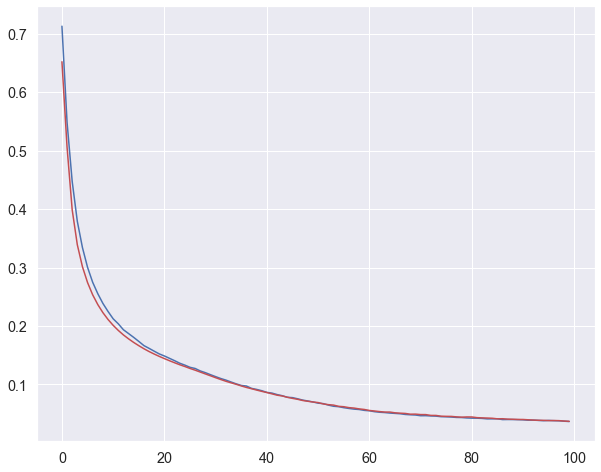

In [ ]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [ ]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.946586,0.973461,0.970628,0.957593,0.974287,0.964511
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.285904,0.224184,0.228186,0.229569,0.237044,0.240977


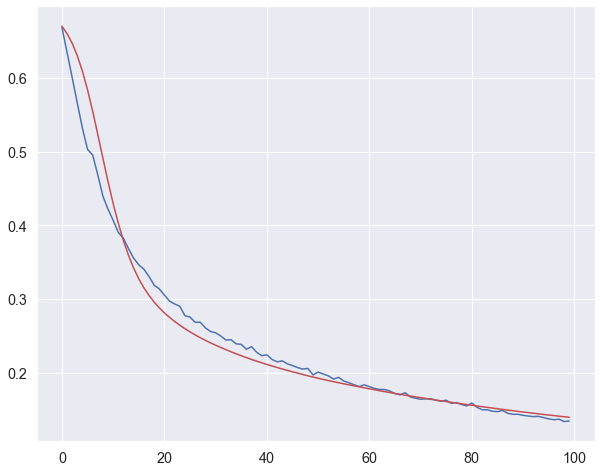

In [ ]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [ ]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.976597,0.976585,0.974879,0.964429,0.974862,0.973470
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.192537,0.185733,0.181788,0.221870,0.234773,0.203340


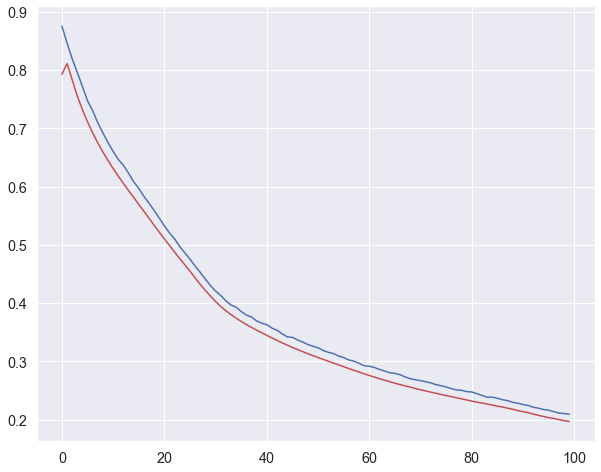

In [ ]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [ ]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.926083,0.943965,0.900711,0.929963,0.947466,0.929637
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.475706,0.470456,0.456826,0.529660,0.462567,0.479043


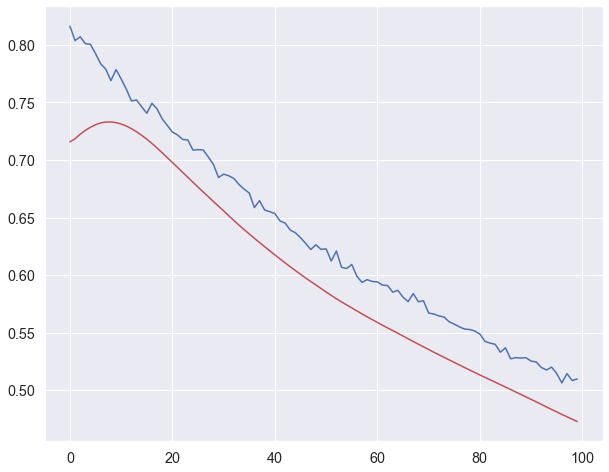

In [ ]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [ ]:
def propensity_score_functANN(dataset,model,dataset2):
    
    dataset2.columns = dataset2.columns.str.strip() 
    if 're74' in dataset2.columns: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [ ]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab)



In [ ]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN_FS1.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN_FS1.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN_FS1.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN_FS1.csv')

## Bar plots of model performance

In [ ]:
# Average accuracy
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

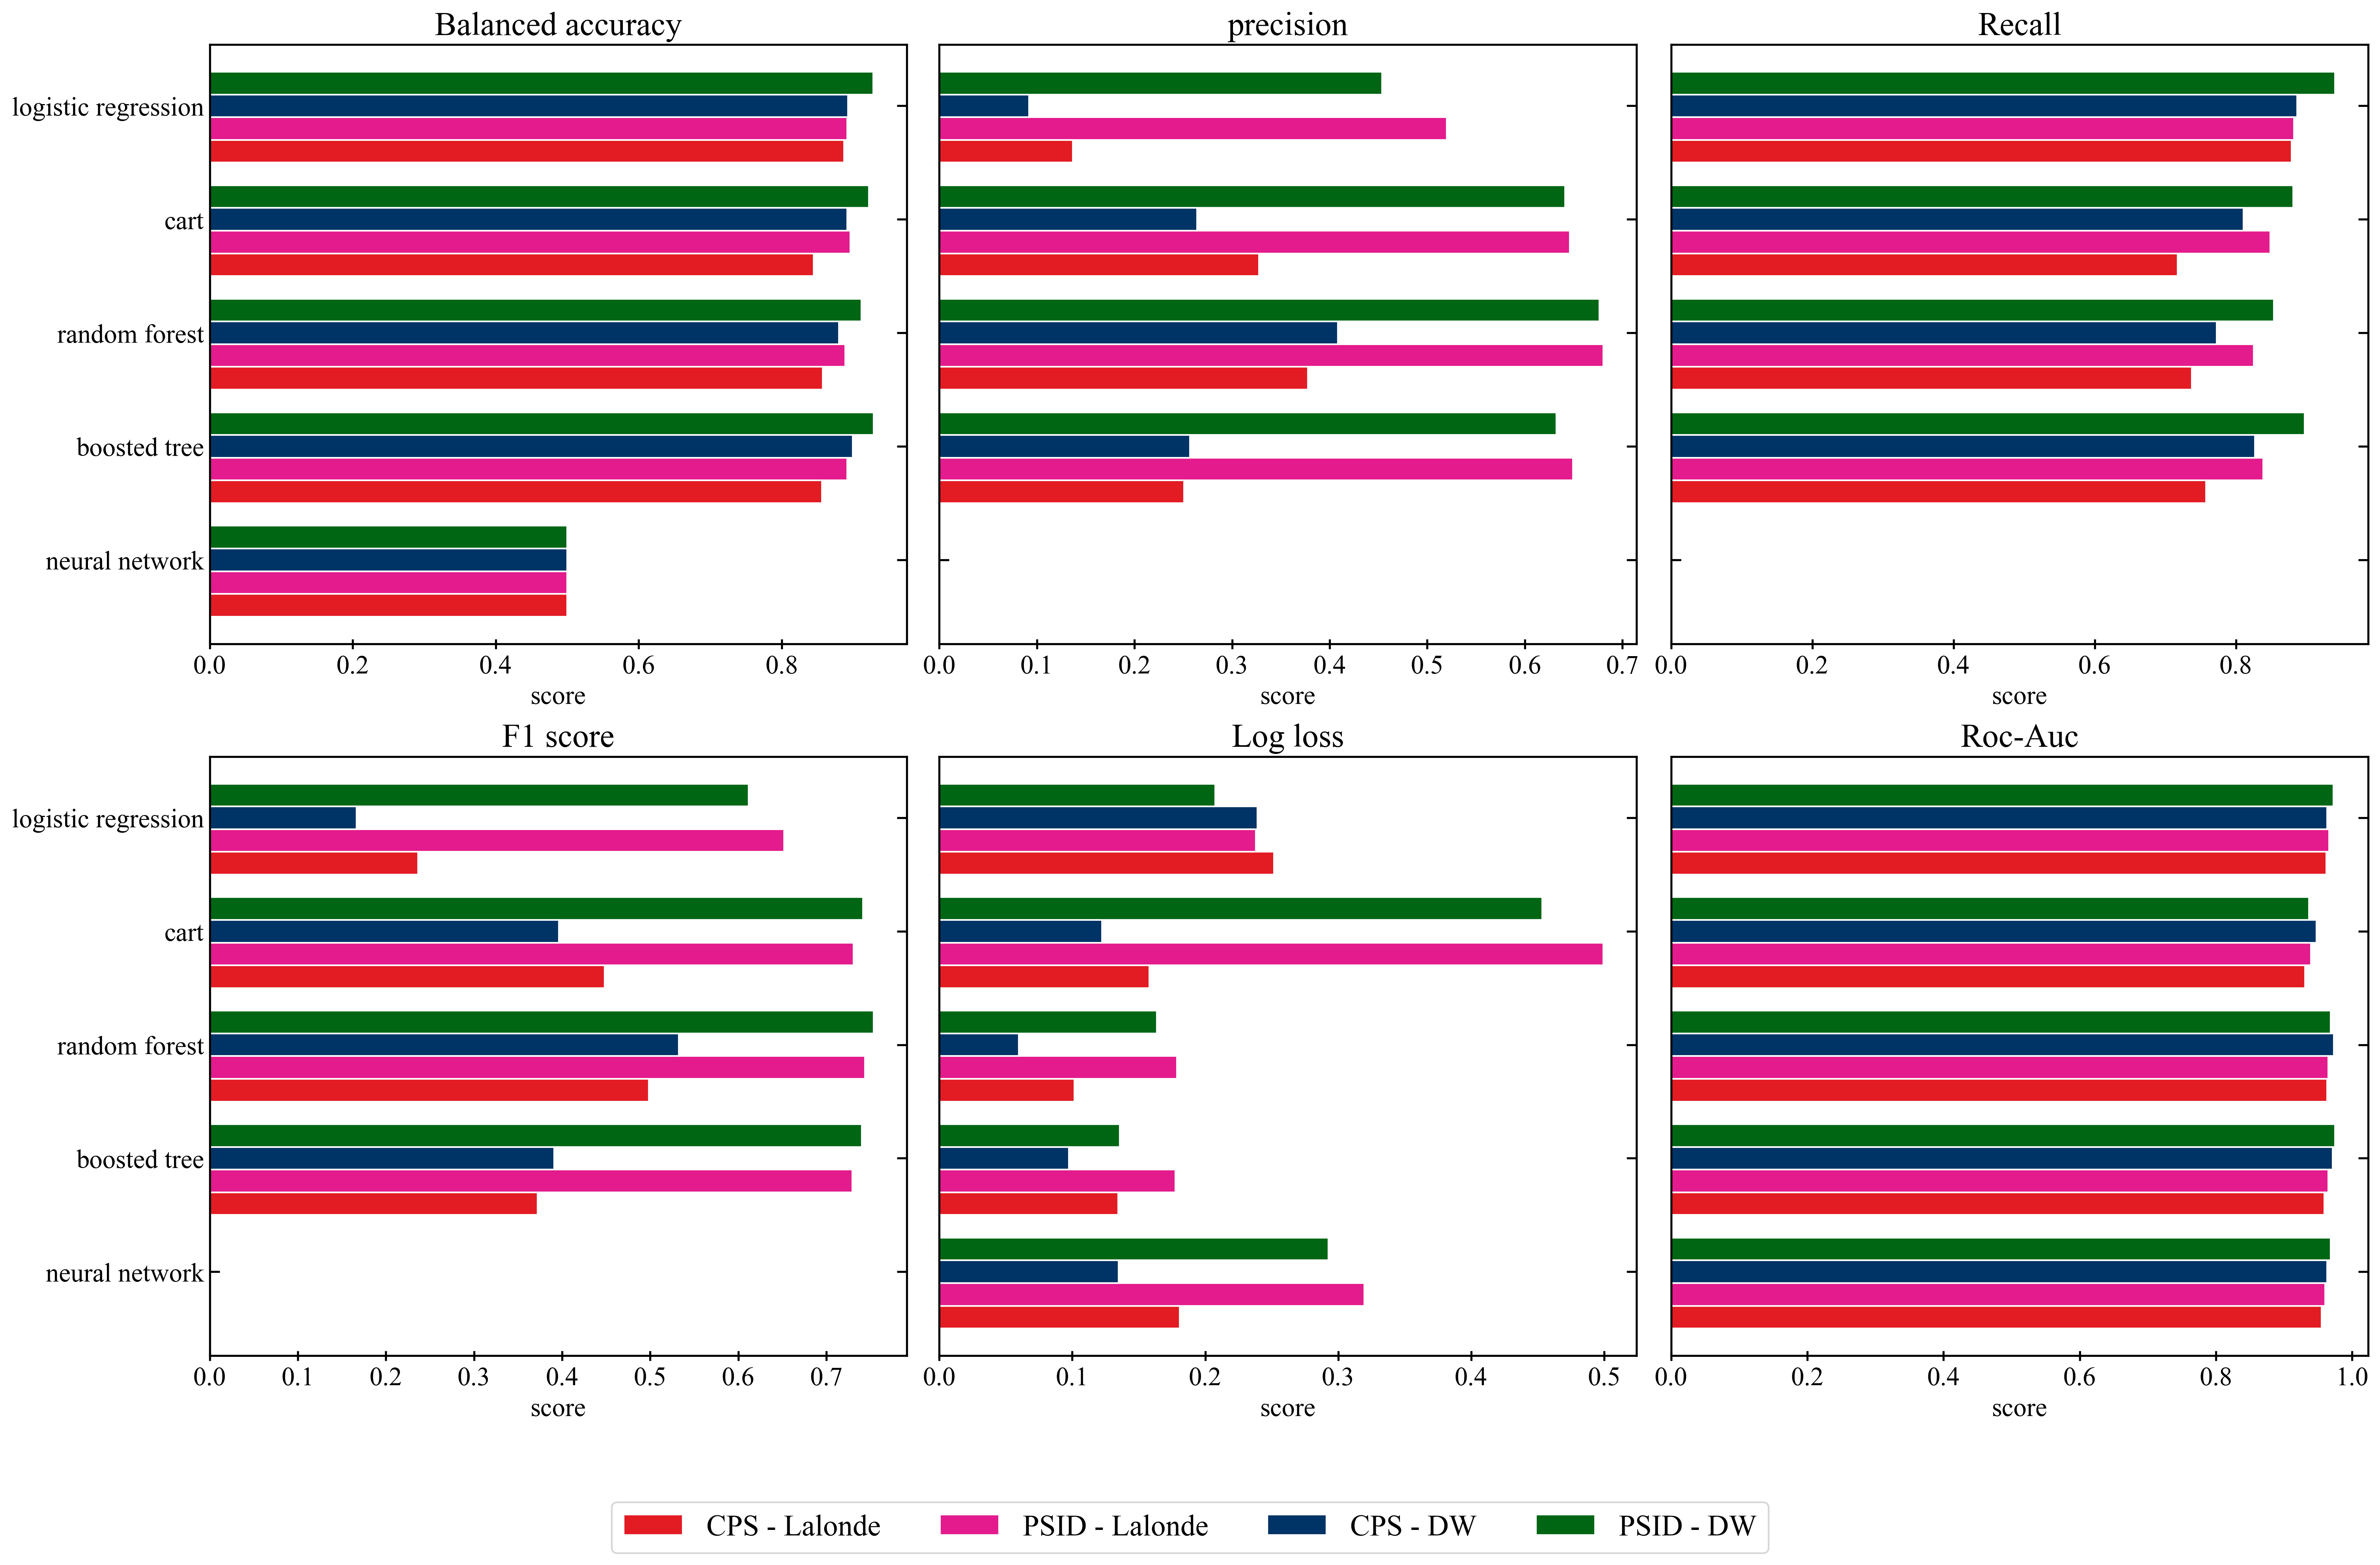

In [ ]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#E31B23" # CPS lalonde
colour2 = "#e31b8c" # PSID lalonde
colour3 = "#003366" # CPS dehwab
colour4 = "#006614" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig8_training_evaluation_averages.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [ ]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [ ]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    

In [ ]:

# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 

# covariates used in each mdoel 
logit_vars = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
logit_vars2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u74','u75','educ_re75']
tree_vars = ['treat','age','education*','black','hispanic','married','nodegree','re75']
tree_vars2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
ann_vars = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13','education_14', 'education_15', 'education_16', 'education_17']
ann_vars2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12',  'education_13', 'education_14', 'education_15', 'education_16', 'education_17']
continuos_vars = ['ageboxcox','lnre75'] 
continuos_vars2= ['ageboxcox','lnre74','lnre75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_22306/3253230798.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_22306/3253230798.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn

In [ ]:
# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

In [ ]:
logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:16:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:21:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:25:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


[00:21:57] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "booser", "mind_child_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/calibration.py:964: FutureWarning: The normalize argument is deprecated in v1.1 and will be removed in v1.3. Explicitly normalizing y_prob will reproduce this behavior, but it is recommended that a proper probability is used (i.e. a classifier's `predict_proba` positive class or `decision_function` output calibrated with `CalibratedClassifierCV`).
  warnings.warn(


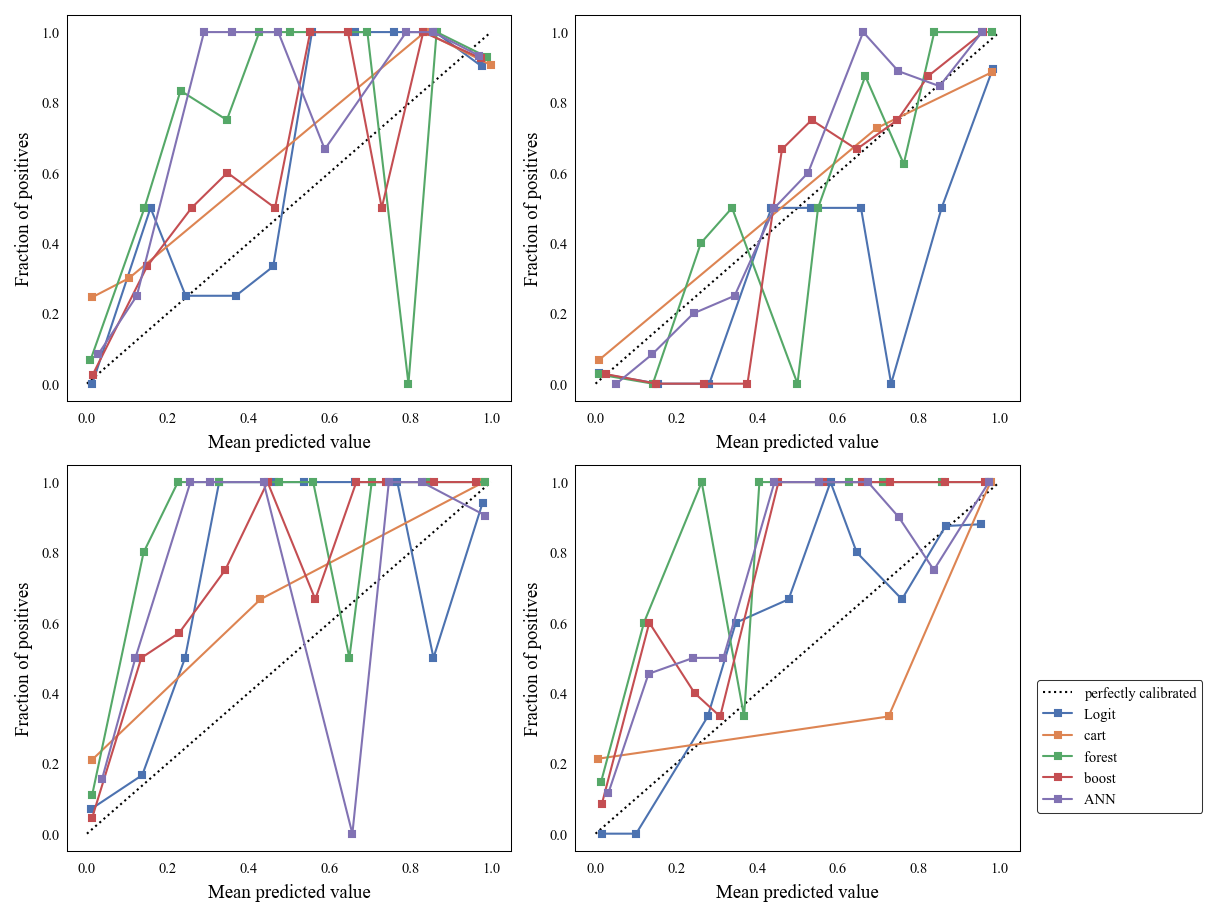

In [ ]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,6))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')


marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')


plt.legend(loc=(1.04, 0.1))
plt.show()

# Further matching 

In [ ]:





plt.barh(boston.feature_names, rf.feature_importances_)

## Box plots

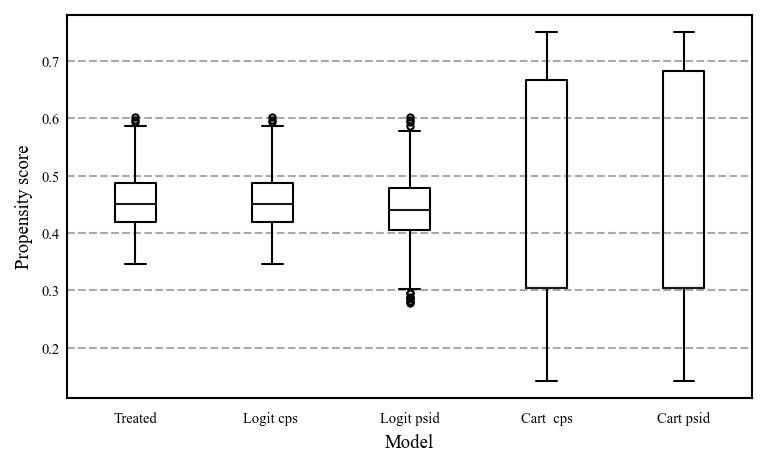

In [ ]:
# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()